# Data Cleanup for Various Future Datafeeds

# Notebook's Environment

In [50]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0

!python --version

Python 3.11.8


# Cloud Environment Setup

In [51]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import glob
from datetime import datetime
from pandas.tseries.offsets import BDay, Day
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

warnings.filterwarnings("ignore")

CLEAN_DATA_PATH = f".{os.sep}data"
DATA_PATH = f".{os.sep}data{os.sep}unstructureddata"
print("running localhost!")

running localhost!


# Get Data

In [52]:
class StockFeat:
    DATETIME = "Datetime"
    OPEN = "Open"
    HIGH = "High"
    LOW = "Low"
    CLOSE = "Close"
    VOLUME = "Volume"
    list = [OPEN, HIGH, LOW, CLOSE, VOLUME]

class YFinanceOptions:
    INDEX = "Datetime"
    MIN1_RANGE = 7 - 1
    MIN15_RANGE = 60 - 1
    HOUR_RANGE = 730 - 1
    DAY_RANGE = 7300 - 1
    D1="1d"
    H1="1h"
    M15="15m"
    M1="1m"
    DATE_TIME_FORMAT = "%Y-%m-%d"
    DATE_TIME_HRS_FORMAT = '%Y-%m-%d %H:%M:%S %Z'

PERIOD_PD_FREQ = {
    YFinanceOptions.M1: '1T',
    YFinanceOptions.M15: '15T',
}

INTERVAL = YFinanceOptions.M15
DATE_TIME_FORMAT = "%Y-%m-%d"
END_DATE = pd.Timestamp(datetime.now()).strftime(DATE_TIME_FORMAT)
START_DATE =  pd.Timestamp(datetime.now() - Day(YFinanceOptions.MIN15_RANGE)).strftime(DATE_TIME_FORMAT)

SNP_FUT = "ES=F"
NSDQ_FUT = "NQ=F"
VOLATILITY_FUT= "^VIX"
RUS_FUT = "RTY=F"
RATES_FUT = "2YY=F"

MARKET_FUTS = [SNP_FUT, NSDQ_FUT, VOLATILITY_FUT, RUS_FUT, RATES_FUT]

# Metals
GOLD_FUT = "GC=F"
SILVER_FUT = "SI=F"
COPPER_FUT = "HG=F"
PLATINUM_FUT = "PL=F"
PALLADIUM_FUT = "PA=F"

METALS_FUTS = [GOLD_FUT, SILVER_FUT, COPPER_FUT, PLATINUM_FUT, PALLADIUM_FUT]

# Energy
CRUDEOIL_FUT = "CL=F"
NATURALGAS_FUT = "NG=F"
HEATINGOIL_FUT = "HO=F"
RBOB_FUT = "RB=F"


ENERGY_FUTS = [CRUDEOIL_FUT, NATURALGAS_FUT, HEATINGOIL_FUT, RBOB_FUT]

# Agri
CORN_FUT = "ZC=F"
SOYOIL_FUT = "ZL=F"
KCWHEAT_FUT = "KE=F"
SOYBEAN_FUT = "ZS=F"
SOYBEANMEAL_FUT = "ZM=F"
WHEAT_FUT = "ZW=F"
LIVECATTLE_FUT = "LE=F"
LEANHOG_FUT = "HE=F"
FEEDERCATTLE_FUT = "GF=F"
MILK_FUT = "DC=F"

AGRI_FUTS = [CORN_FUT, SOYOIL_FUT, KCWHEAT_FUT, SOYBEAN_FUT, SOYBEANMEAL_FUT, WHEAT_FUT, LIVECATTLE_FUT, LEANHOG_FUT, FEEDERCATTLE_FUT, MILK_FUT]

TICKER_SYMBOLS = AGRI_FUTS + METALS_FUTS + ENERGY_FUTS + MARKET_FUTS

In [53]:
import yfinance as yf
from scipy.stats import skew, kurtosis

def get_yf_tickers_df(tickers_symbols, start, end, interval=INTERVAL, datadir=DATA_PATH):
    tickers = {}
    earliest_end= pd.to_datetime(datetime.strptime(end,YFinanceOptions.DATE_TIME_FORMAT)).tz_localize("UTC")
    latest_start = pd.to_datetime(datetime.strptime(start,YFinanceOptions.DATE_TIME_FORMAT)).tz_localize("UTC")
    os.makedirs(datadir, exist_ok=True)
    for symbol in tickers_symbols:
        cached_file_path = f"{datadir}/{symbol}-{start.split(' ')[0]}-{end.split(' ')[0]}-{interval}.csv"
        print(f"Checking file: {cached_file_path}")
        if os.path.exists(cached_file_path):
            print(f"loading from {cached_file_path}")
            df = pd.read_csv(cached_file_path, parse_dates= True, index_col=0)
            try:
                df.index = pd.to_datetime(df.index).tz_localize('US/Central').tz_convert('UTC')
            except Exception as e:
                df.index = pd.to_datetime(df.index).tz_convert('UTC')
            assert len(df) > 0, "Empty data"
        else:
            df = yf.download(
                symbol,
                start=start,
                end=end,
                progress=True,
                interval=interval
            )
            assert len(df) > 0, "No data pulled"
            try:
                df.index = pd.to_datetime(df.index).tz_localize('US/Central').tz_convert('UTC')
            except Exception as e:
                df.index = pd.to_datetime(df.index).tz_convert('UTC')
        # Use adjusted close if available.
        if 'Adj Close' in df.columns:
            assert 'Close' in df.columns
            df.drop(columns=['Close'], inplace=True)
            df.rename(columns={'Adj Close': 'Close'}, inplace=True)
        min_date = df.index.min()
        max_date = df.index.max()
        nan_count = df["Close"].isnull().sum()
        skewness = round(skew(df["Close"].dropna()), 2)
        kurt = round(kurtosis(df["Close"].dropna()), 2)
        outliers_count = (df["Close"] > df["Close"].mean() + (3 * df["Close"].std())).sum()
        print(
            f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
        )
        tickers[symbol] = df

        if min_date > latest_start:
            latest_start = min_date
        if max_date < earliest_end:
            earliest_end = max_date

    nyse = mcal.get_calendar('CME_Agriculture')
    schedule = nyse.schedule(start_date=latest_start, end_date=earliest_end)
    all_trading_days = mcal.date_range(schedule, frequency=PERIOD_PD_FREQ[interval], tz='UTC', normalize=True)

    for symbol, df in tickers.items():
        df_filtered = df[(df.index >= latest_start) & (df.index <= earliest_end)]
        df_reindexed = df_filtered.reindex(all_trading_days, method='nearest')
        df_reindexed.index = pd.to_datetime(df_reindexed.index)
        df_reindexed = df_reindexed[~df_reindexed.index.duplicated(keep='first')]
        df_reindexed.index.name = 'Date'
        tickers[symbol] = df_reindexed


        cached_file_path = f"{datadir}/{symbol}-{start.split(' ')[0]}-{end.split(' ')[0]}-{interval}.csv"
        if not os.path.exists(cached_file_path):
            df_reindexed.to_csv(cached_file_path, index=True)

    return tickers, latest_start, earliest_end

tickers, latest_start, earliest_end = get_yf_tickers_df(TICKER_SYMBOLS, start=START_DATE, end=END_DATE)

Checking file: .\data\unstructureddata/ZC=F-2024-03-20-2024-05-18-15m.csv
loading from .\data\unstructureddata/ZC=F-2024-03-20-2024-05-18-15m.csv
ZC=F => min_date: 2024-03-19 22:16:00+00:00, max_date: 2024-05-17 22:00:00+00:00, kurt:-0.27, skewness:0.47, outliers_count:0,  nan_count: 0
Checking file: .\data\unstructureddata/ZL=F-2024-03-20-2024-05-18-15m.csv
loading from .\data\unstructureddata/ZL=F-2024-03-20-2024-05-18-15m.csv
ZL=F => min_date: 2024-03-19 22:16:00+00:00, max_date: 2024-05-17 22:00:00+00:00, kurt:-1.39, skewness:0.12, outliers_count:0,  nan_count: 0
Checking file: .\data\unstructureddata/KE=F-2024-03-20-2024-05-18-15m.csv
loading from .\data\unstructureddata/KE=F-2024-03-20-2024-05-18-15m.csv
KE=F => min_date: 2024-03-19 22:16:00+00:00, max_date: 2024-05-17 22:00:00+00:00, kurt:-1.11, skewness:0.56, outliers_count:0,  nan_count: 0
Checking file: .\data\unstructureddata/ZS=F-2024-03-20-2024-05-18-15m.csv
loading from .\data\unstructureddata/ZS=F-2024-03-20-2024-05-18-1

De-duplicate and combine dataframes.

In [54]:
for ticker in TICKER_SYMBOLS:
    file_pattern = f'{ticker}*.csv'
    files = glob.glob(f"{DATA_PATH}{os.sep}{ticker}*-{INTERVAL}.csv")
    assert files and len(files) > 0

    dataframes = []
    for file in files:
        df = pd.read_csv(file, index_col=0, parse_dates=True)
        dataframes.append(df)

    combined_df = pd.concat(dataframes)
    combined_df = combined_df[~combined_df.index.duplicated(keep='first')]
    combined_df.sort_index(inplace=True)
    combined_df.to_csv(f'{DATA_PATH}{os.sep}{ticker}-combined-{INTERVAL}.csv')

# Clean Data

In [55]:
def get_prefix(filename):
    prefix = filename.split(os.sep)[-1].split("-")[0].replace("=F", "")
    return prefix

files = glob.glob(f'{DATA_PATH}{os.sep}*-combined-{INTERVAL}.csv')
assert files and len(files) > 0

fut_tickers = []
df_list = []

for f in files:
    print(f)
    prefix = get_prefix(f)
    fut_tickers.append(prefix)
    df_temp = pd.read_csv(f, index_col="Date", parse_dates=True)
    # TODO: Use bid ask here.
    df_temp["Spread"] = df_temp["High"] - df_temp["Low"]

    df_temp.columns = [prefix + "_" + col for col in df_temp.columns]
    df_temp = df_temp.apply(
        pd.to_numeric, errors="coerce"
    )

    df_list.append(df_temp)

.\data\unstructureddata\2YY=F-combined-15m.csv
.\data\unstructureddata\CL=F-combined-15m.csv
.\data\unstructureddata\DC=F-combined-15m.csv
.\data\unstructureddata\ES=F-combined-15m.csv
.\data\unstructureddata\GC=F-combined-15m.csv
.\data\unstructureddata\GF=F-combined-15m.csv
.\data\unstructureddata\HE=F-combined-15m.csv
.\data\unstructureddata\HG=F-combined-15m.csv
.\data\unstructureddata\HO=F-combined-15m.csv
.\data\unstructureddata\KE=F-combined-15m.csv
.\data\unstructureddata\LE=F-combined-15m.csv
.\data\unstructureddata\NG=F-combined-15m.csv
.\data\unstructureddata\NQ=F-combined-15m.csv
.\data\unstructureddata\PA=F-combined-15m.csv
.\data\unstructureddata\PL=F-combined-15m.csv
.\data\unstructureddata\RB=F-combined-15m.csv
.\data\unstructureddata\RTY=F-combined-15m.csv
.\data\unstructureddata\SI=F-combined-15m.csv
.\data\unstructureddata\ZC=F-combined-15m.csv
.\data\unstructureddata\ZL=F-combined-15m.csv
.\data\unstructureddata\ZM=F-combined-15m.csv
.\data\unstructureddata\ZS=F-com

In [56]:
futs_df = pd.concat(df_list, axis=1)
try:
    futs_df.index = futs_df.index.tz_localize("GMT")
except Exception as e:
    print(e)
    # Probably already TZ aware
futs_df.sort_index(inplace=True)
futs_df = futs_df.iloc[futs_df.notnull().all(axis=1).argmax() :]
futs_df.interpolate(method="time", inplace=True)

assert not futs_df.isnull().any().any()
print(fut_tickers)
print(f"Dataset Shape: {futs_df.shape}")

futs_df.head(2)

Already tz-aware, use tz_convert to convert.
['2YY', 'CL', 'DC', 'ES', 'GC', 'GF', 'HE', 'HG', 'HO', 'KE', 'LE', 'NG', 'NQ', 'PA', 'PL', 'RB', 'RTY', 'SI', 'ZC', 'ZL', 'ZM', 'ZS', 'ZW', '^VIX']
Dataset Shape: (4224, 144)


,2YY_Open,2YY_High,2YY_Low,2YY_Close,2YY_Volume,2YY_Spread,CL_Open,CL_High,CL_Low,CL_Close,...,ZW_Low,ZW_Close,ZW_Volume,ZW_Spread,^VIX_Open,^VIX_High,^VIX_Low,^VIX_Close,^VIX_Volume,^VIX_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-17 22:16:00+00:00,4.662,4.662,4.662,4.662,1,0.0,81.769997,81.769997,81.290001,81.419998,...,535.0,535.75,7123,3.75,14.75,14.81,14.73,14.81,0,0.080001
2024-03-17 22:31:00+00:00,4.662,4.662,4.662,4.662,1,0.0,81.769997,81.769997,81.290001,81.419998,...,535.0,535.75,7123,3.75,14.75,14.81,14.73,14.81,0,0.080001


In [57]:
PRICE_COLS =["Close", "Open", "High", "Low", "Spread"]
def create_fut_rets_df(df, price_types = PRICE_COLS):
    log_data = {}
    pct_change_data = {}

    for price_type in tqdm(price_types):
        for column in tqdm(df.columns):
            if price_type in column:
                log_data[f"{column}_lp"] = np.log(df[column])
                pct_change_data[f"{column}_pc"] = df[column].pct_change() * 100
    log_fut_df = pd.DataFrame(log_data, index=df.index).bfill()
    pct_changes_df = pd.DataFrame(pct_change_data, index=df.index).bfill()
    combined_df = pd.concat([log_fut_df, pct_changes_df], axis=1)

    return combined_df

fut_rets_df = create_fut_rets_df(futs_df)
fut_rets_df.head(2)

100%|██████████| 144/144 [00:00<00:00, 10737.61it/s]


100%|██████████| 5/5 [00:00<00:00, 72.80it/s]


,2YY_Close_lp,CL_Close_lp,DC_Close_lp,ES_Close_lp,GC_Close_lp,GF_Close_lp,HE_Close_lp,HG_Close_lp,HO_Close_lp,KE_Close_lp,...,PL_Spread_pc,RB_Spread_pc,RTY_Spread_pc,SI_Spread_pc,ZC_Spread_pc,ZL_Spread_pc,ZM_Spread_pc,ZS_Spread_pc,ZW_Spread_pc,^VIX_Spread_pc
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-17 22:16:00+00:00,1.539445,4.399621,2.772589,8.555885,7.677586,5.536744,4.460722,1.422626,1.015122,6.342121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-17 22:31:00+00:00,1.539445,4.399621,2.772589,8.555885,7.677586,5.536744,4.460722,1.422626,1.015122,6.342121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Save Data

In [58]:
futs_df.to_csv(f"{CLEAN_DATA_PATH}{os.sep}futures_{INTERVAL}.csv")

# EDA

## Skew, Kurosis and Outliers

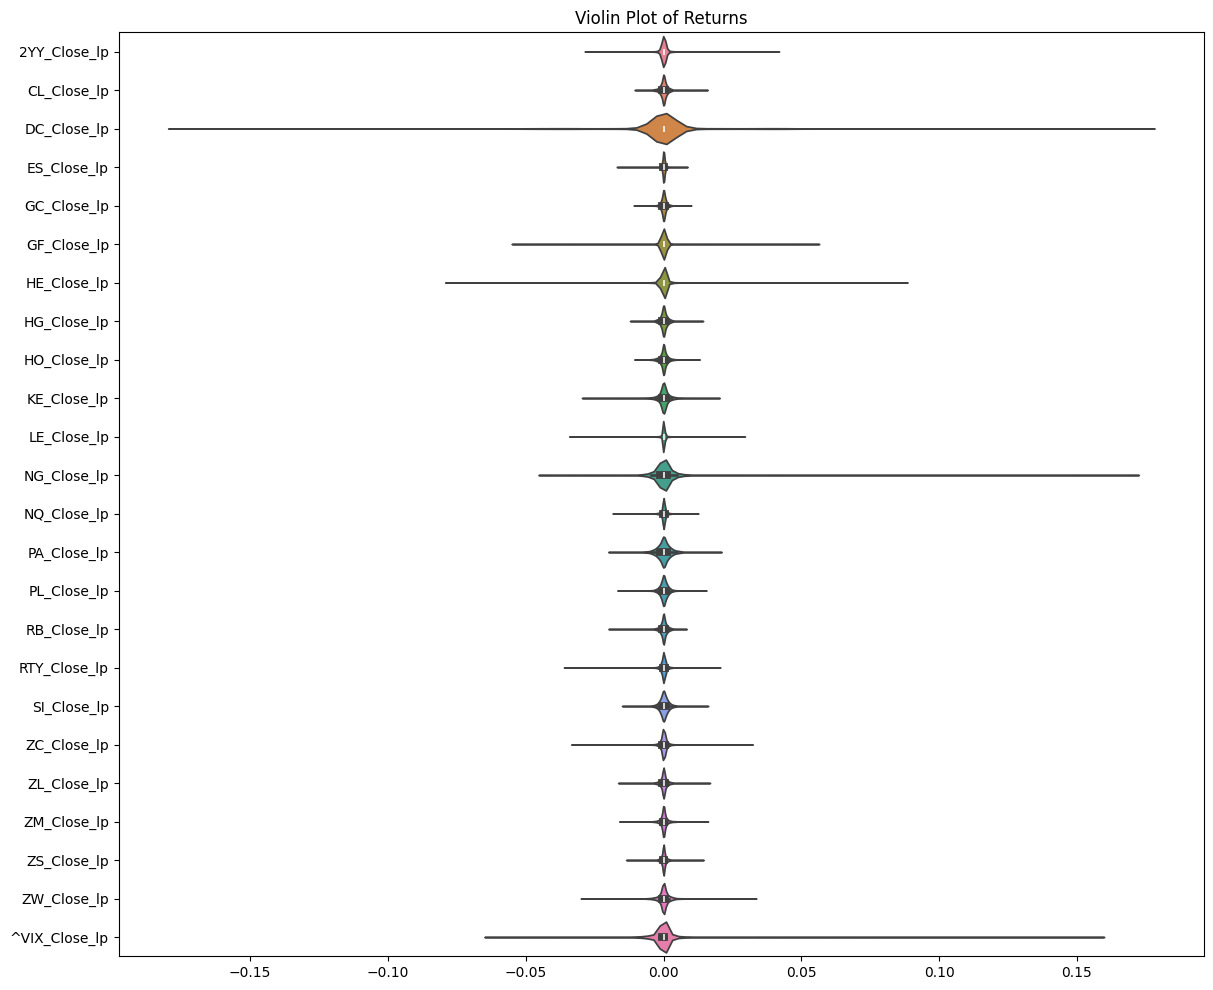

In [59]:
fut_lp = fut_rets_df.filter(regex="^.*Close_lp")
fut_lr = fut_lp.diff(1).fillna(0)
plt.figure(figsize=(14, 12))
ax = sns.violinplot(data=fut_lr, orient='h', scale='width')

plt.title("Violin Plot of Returns")
plt.show()

## Data Mining for Correlations


## Autoregressive

In [37]:
from statsmodels.tsa.stattools import pacf
from tqdm import tqdm
from scipy.stats import norm

def get_significant_lags(series, alpha=0.05):
    pacf_values = pacf(series.dropna(), nlags=40)
    n = len(series.dropna())
    z_critical = norm.ppf(1 - alpha / 2)  # two-tailed test
    critical_value = z_critical / np.sqrt(n) # the PCF value
    significant_lags = [i for i, p in enumerate(pacf_values) if abs(p) > critical_value]
    significant_lags = significant_lags[2:] # Drop lag 0,1, its always AR
    significant_pacf_values = [p for p in pacf_values if abs(p) > critical_value]
    significant_pacf_values = significant_pacf_values[2:]
    return significant_lags, significant_pacf_values

def get_ar_stats(df, alpha=0.05):
    df.index = pd.DatetimeIndex(df.index).to_period('T')
    ar_results = []
    for col in tqdm(df.columns, desc="get_ar_stats"):
        significant_lags, significant_pacf_values = get_significant_lags(df[col], alpha)
        ar_results.append({
            'Futs': col,
            'Lags': significant_lags,
            'PACF Values': significant_pacf_values
        })

    ar_df = pd.DataFrame(ar_results)
    return ar_df

ar_df = get_ar_stats(futs_df.filter(regex='_Close$'))
ar_df


get_ar_stats: 100%|██████████| 24/24 [00:00<00:00, 47.49it/s]


,Futs,Lags,PACF Values
0,2YY_Close,"[2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 17, 20, 24, ...","[0.19657632016374002, 0.16740989404003473, 0.1..."
1,CL_Close,"[4, 11, 14, 15, 40]","[-0.0364394045872941, 0.03372150385465784, -0...."
2,DC_Close,"[2, 3, 4, 5, 6, 7, 8, 13, 14, 17, 18, 19, 21, ...","[0.33667343038664005, 0.17848614263480134, 0.1..."
3,ES_Close,"[3, 5, 7, 10, 12, 14, 16, 22, 27]","[-0.05881773737356488, 0.047435232318730265, 0..."
4,GC_Close,[34],[0.03227225308240391]
5,GF_Close,"[2, 3, 4, 5, 6, 8, 9, 11, 13, 14, 16, 19]","[0.4926011231622985, 0.18196269717379773, 0.19..."
6,HE_Close,"[2, 3, 4, 11, 12, 40]","[0.35516392195927965, 0.14015390422680166, 0.0..."
7,HG_Close,"[27, 32]","[-0.03559162543557149, -0.04412070124724402]"
8,HO_Close,[3],[-0.03050816746450082]
9,KE_Close,"[2, 3, 4, 17, 22, 34, 39, 40]","[0.2070258033611406, 0.10264814602434644, 0.04..."


In [42]:
def find_common_lags(ar_df):
    lag_dict = {}
    for index, row in ar_df.iterrows():
        for lag in row['Lags']:
            if lag in lag_dict:
                lag_dict[lag].append(row['Futs'])
            else:
                lag_dict[lag] = [row['Futs']]

    common_lags = {lag: futs for lag, futs in lag_dict.items() if len(futs) > 1}

    common_lags_df = pd.DataFrame(list(common_lags.items()), columns=['Lag', 'Futs'])
    common_lags_df['Futs'] = common_lags_df['Futs'].apply(lambda futs: ', '.join(futs))

    return common_lags_df


commmon_ar_df = find_common_lags(ar_df)
commmon_ar_df

,Lag,Futs
0,2,"2YY_Close, DC_Close, GF_Close, HE_Close, KE_Cl..."
1,3,"2YY_Close, DC_Close, ES_Close, GF_Close, HE_Cl..."
2,4,"2YY_Close, CL_Close, DC_Close, GF_Close, HE_Cl..."
3,5,"2YY_Close, DC_Close, ES_Close, GF_Close, LE_Cl..."
4,6,"2YY_Close, DC_Close, GF_Close, LE_Close, PA_Cl..."
5,8,"2YY_Close, DC_Close, GF_Close, LE_Close, RTY_C..."
6,9,"2YY_Close, GF_Close, RTY_Close, ZC_Close, ZM_C..."
7,10,"2YY_Close, ES_Close, LE_Close, ZC_Close, ^VIX_..."
8,11,"2YY_Close, CL_Close, GF_Close, HE_Close, LE_Cl..."
9,13,"2YY_Close, DC_Close, GF_Close, LE_Close, RTY_C..."


## Correlations between Futures

In [18]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import pearsonr
from itertools import combinations

LAGS = [1, 4, 16, 32]
MAX_DIFF = 2


def make_stationary(series, max_diff=MAX_DIFF):
    result = adfuller(series.dropna(), autolag="AIC")
    p_value = result[1]
    if p_value < 0.05:
        return series, 0

    diff_count = 0
    differenced_series = series.copy()
    while p_value >= 0.05 and diff_count < max_diff:
        differenced_series = differenced_series.diff().dropna()
        result = adfuller(differenced_series, autolag="AIC")
        p_value = result[1]
        diff_count += 1
        if p_value < 0.05:
            break

    return differenced_series, diff_count


def calculate_correlations(data, lags=LAGS, alpha=0.05, corr_threshold=0.25):
    correlations = {}

    rets = data.filter(regex="(_Close_lp)$")
    pairs = list(combinations(rets.columns, 2))
    for col1, col2 in tqdm(pairs, desc="calculate_correlations", total=len(pairs)):
        series1, _ = make_stationary(rets[col1])
        series2, _ = make_stationary(rets[col2])

        for lag in lags:
            lagged_series2 = series2.shift(lag).dropna()
            truncated_series1 = series1.iloc[lag:]

            if len(truncated_series1) == 0 or len(truncated_series1) != len(lagged_series2):
                continue

            corr, p_value = pearsonr(truncated_series1, lagged_series2)
            if p_value < alpha and abs(corr) >= corr_threshold:
                correlations[((col1, col2), lag)] = (corr, p_value)

    return correlations

correlation_df = []
correlation_results = calculate_correlations(fut_rets_df)
if len(correlation_results) > 0:
    correlation_df = pd.DataFrame.from_dict(
        correlation_results, orient="index", columns=["Correlation", "P-Value"]
    )
    correlation_df = correlation_df.sort_values(by="Correlation", ascending=False)

correlation_df

calculate_correlations: 100%|██████████| 276/276 [05:19<00:00,  1.16s/it]


,Correlation,P-Value
"((RTY_Close_lp, ^VIX_Close_lp), 4)",-0.524672,3.448297e-297
"((NQ_Close_lp, ^VIX_Close_lp), 4)",-0.617290,0.000000e+00
"((ES_Close_lp, ^VIX_Close_lp), 4)",-0.660770,0.000000e+00


## Data Mining for Co-Integrations

In [16]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import itertools
from numpy.linalg import LinAlgError

subsets = {
        'Market': MARKET_FUTS,
        'Metals': METALS_FUTS,
        'Energy': ENERGY_FUTS,
        'Agri': AGRI_FUTS,
        'All': TICKER_SYMBOLS
    }

def johansen_cointegration_test(df, alpha=0.05):
    assert df.shape[1] > 0

    data = df.values
    johansen_result = coint_johansen(data, det_order=0, k_ar_diff=1)

    trace_stat = johansen_result.lr1
    trace_crit_values = johansen_result.cvt

    def get_crit_index(alpha):
        alpha_levels = [0.10, 0.05, 0.01]
        if alpha in alpha_levels:
            return alpha_levels.index(alpha)
        else:
            raise ValueError(f"Alpha {alpha} out of valid range {alpha_levels}")

    crit_index = get_crit_index(alpha)
    num_cointegrated_vectors = sum(trace_stat > trace_crit_values[:, crit_index])
    return num_cointegrated_vectors, johansen_result

def run_johansen_on_subsets(fut_rets_df):
    results = []

    # Test each subset
    for subset_name, tickers in subsets.items():
        cols = [t.replace("=F", "")+"_Close_lp" for t in tickers]
        filtered_df = fut_rets_df[cols]
        if len(filtered_df.columns) < 2:
            continue
        try:
            num_coint_vectors, johansen_result = johansen_cointegration_test(filtered_df)
            results.append({
                'Subset': subset_name,
                'Coints': num_coint_vectors
            })
        except LinAlgError as e:
            results.append({
                'Subset': subset_name,
                'Coints': None,
            })

    # Test combinations of subsets
    subset_keys = list(subsets.keys())
    for i in range(2, len(subset_keys) + 1):
        for combination in itertools.combinations(subset_keys, i):
            combined_name = ' + '.join(combination)
            combined_tickers = list(itertools.chain.from_iterable(subsets[key] for key in combination))
            cols = [t.replace("=F", "")+"_Close_lp" for t in combined_tickers]
            filtered_df = fut_rets_df[cols]
            if len(filtered_df.columns) < 2 or len(filtered_df.columns) > 12:
                continue
            try:
                num_coint_vectors, johansen_result = johansen_cointegration_test(filtered_df)
                results.append({
                    'Subset': combined_name,
                    'Coints': num_coint_vectors
                })
            except LinAlgError as e:
                results.append({
                    'Subset': combined_name,
                    'Coints': 0,
                })

    return pd.DataFrame(results)

results = run_johansen_on_subsets(fut_rets_df)
results[results["Coints"] > 1].sort_values("Coints")

C:\Users\adamd\AppData\Local\Temp\ipykernel_25116\2389457898.py:17: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  johansen_result = coint_johansen(data, det_order=0, k_ar_diff=1)


,Subset,Coints
5,Market + Metals,2
6,Market + Energy,2
0,Market,3
3,Agri,4


In [46]:
def get_all_futs_in_coint_subsets():
    coint_subset = set()
    for subset in results[results["Coints"] > 1]['Subset']:
        futures = subset.split(' + ')
        for future in futures:
            coint_subset.update(subsets[future])

    return coint_subset

# We can get a subset of all coint futures across industries, though we
# know there is strong coint in the equities and agri futures,
COINT_FUTS = get_all_futs_in_coint_subsets()
COINT_FUTS = MARKET_FUTS + AGRI_FUTS
print(COINT_FUTS)

['ES=F', 'NQ=F', '^VIX', 'RTY=F', '2YY=F', 'ZC=F', 'ZL=F', 'KE=F', 'ZS=F', 'ZM=F', 'ZW=F', 'LE=F', 'HE=F', 'GF=F', 'DC=F']


In [47]:
from statsmodels.tsa.stattools import coint

def pairwise_cointegration_test(df, coint_cols, alpha=0.05):
    tickers = [t.replace("=F", "")+"_Close_lp" for t in coint_cols]
    results = []

    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            series1 = df[tickers[i]]
            series2 = df[tickers[j]]
            score, p_value, _ = coint(series1, series2)
            if p_value < alpha:
                results.append({
                    'Ticker1': tickers[i].split('_')[0],
                    'Ticker2': tickers[j].split('_')[0],
                    'P-Value': p_value
                })

    results_df = pd.DataFrame(results)
    return results_df


pairwise_coint_results = pairwise_cointegration_test(fut_rets_df, COINT_FUTS)

if not pairwise_coint_results.empty:
    pairwise_coint_results = pairwise_coint_results.sort_values(by='P-Value')
    print(pairwise_coint_results)
else:
    print("No meaningful pairwise cointegration within the supplied alpha")

  Ticker1 Ticker2   P-Value
4      KE      DC  0.003658
5      ZW      DC  0.013110
3      ZC      DC  0.014126
2      ZC      ZW  0.027806
1    ^VIX      ZS  0.028338
0      ES     RTY  0.037678


## Cummulative Returns Visualizations

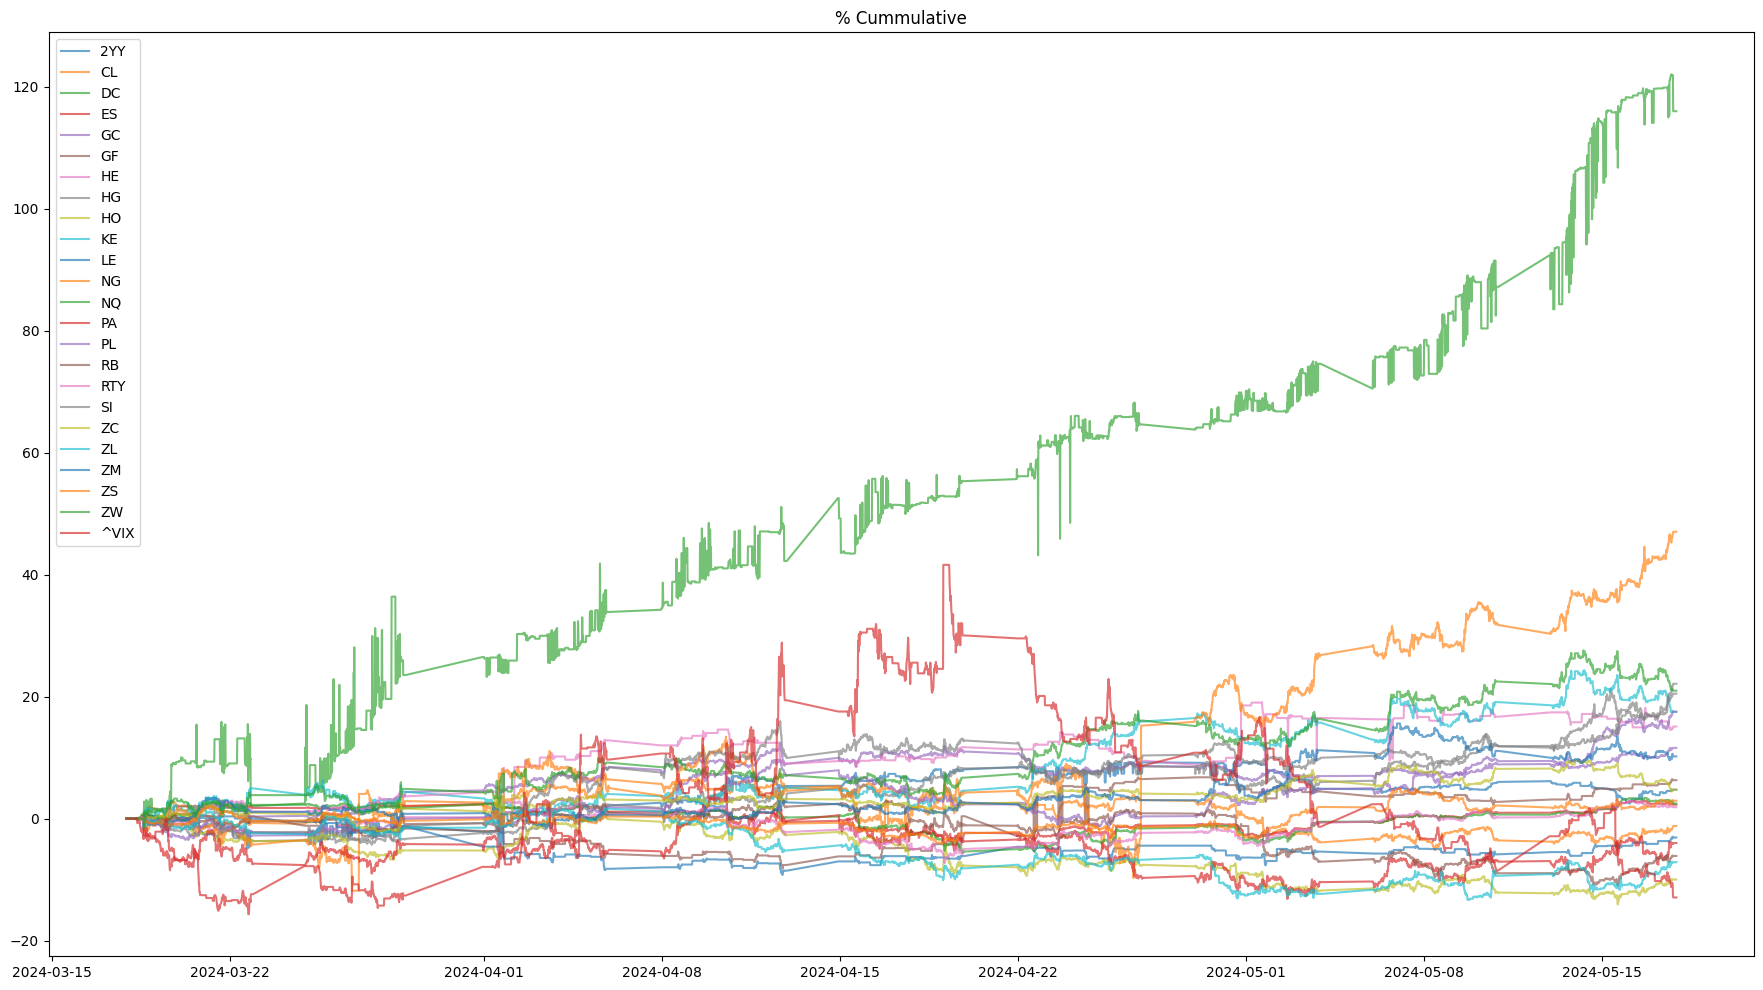

In [48]:
for c in fut_rets_df.columns:
    if c.endswith("_Close_pc"):
        fut_rets_df[c + "_c"] = fut_rets_df[c].cumsum()

# Plotting
plt.figure(figsize=(22, 12))
for c in fut_rets_df.columns:
    if c.endswith("_Close_pc_c"):
        plt.plot(fut_rets_df.index, fut_rets_df[c], label=c.replace("_Close_pc_c", ""), alpha=0.65)
plt.title("% Cummulative")
plt.legend()
plt.show()

## Distributions

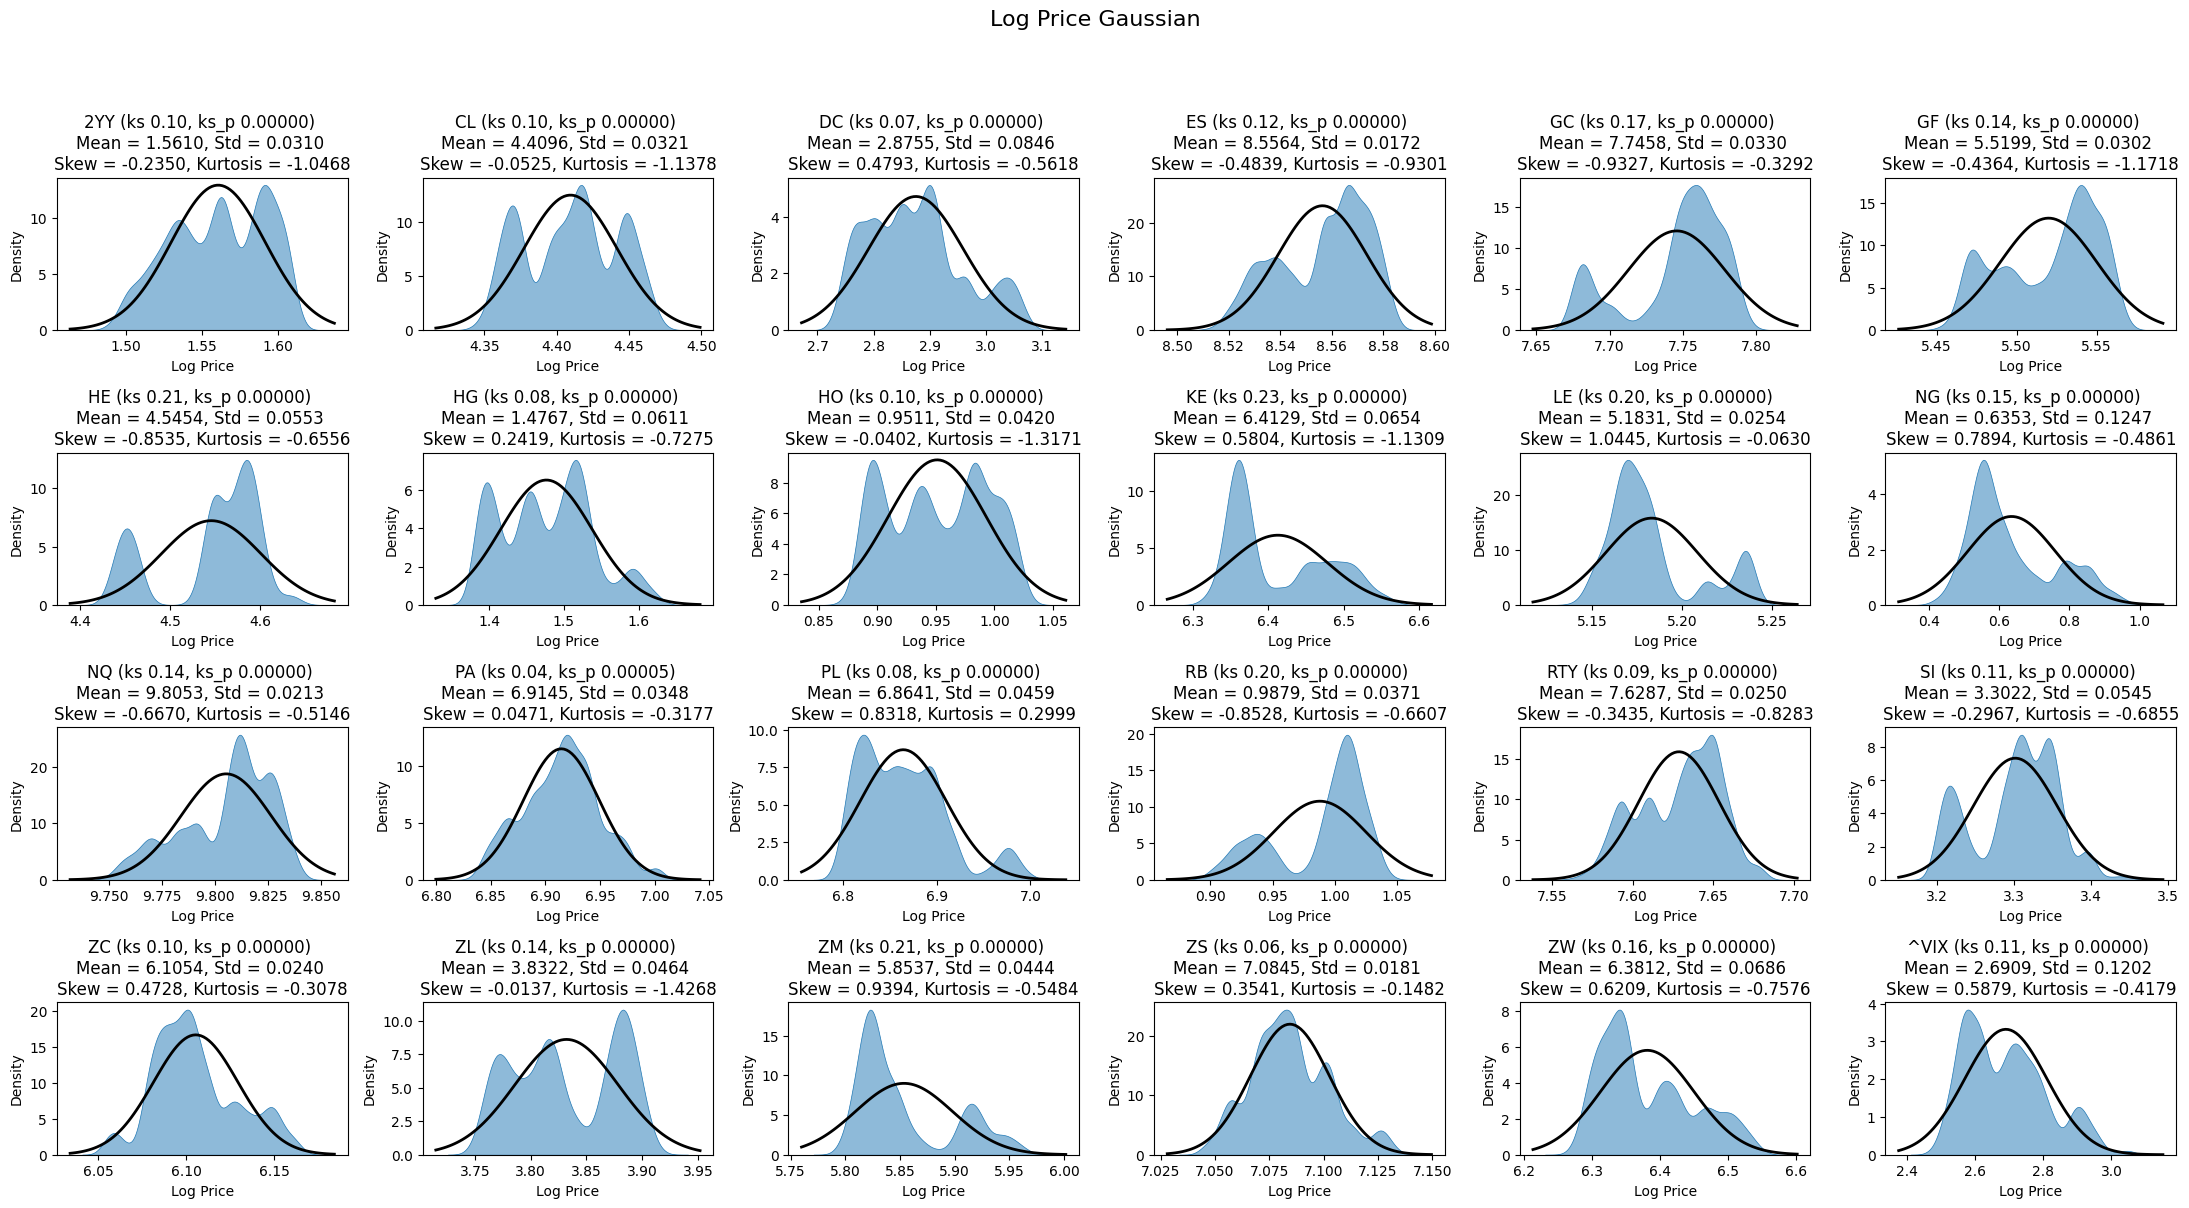

In [61]:
import matplotlib.pyplot as plt
from scipy.stats import norm, skew, kurtosis, kstest

def plot_norm(df):
    columns = df.filter(regex="(_Close(_lp)?)$").columns
    n_cols = len(columns)
    n_cols_adjusted = n_cols // 2 + (n_cols % 2)
    assert len(columns) > 0 and n_cols_adjusted > 0

    fig, axes = plt.subplots(nrows=max(n_cols_adjusted // 2, 1), ncols=max(n_cols_adjusted // 2, 1), figsize=(22, 18))

    axes = axes.flatten()
    fig.suptitle("Log Price Gaussian", fontsize=16)
    for ax, column in zip(axes, columns):
        data = df[column].dropna()
        sns.kdeplot(
            data,
            fill=True,
            common_norm=False,
            alpha=0.5,
            linewidth=0.5,
            ax=ax
        )

        params = norm.fit(data)
        # Kolmogorov-Smirnov Test (KS Test)
        ks_stat, ks_p_value = kstest(data, norm.name, args=params)

        mu, std = params
        xmin, xmax = ax.get_xlim()

        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        ax.plot(x, p, 'k', linewidth=2)

        data_skew = skew(data)
        data_kurtosis = kurtosis(data)

        title = (
            f"{column.split('_')[0]} (ks {ks_stat:.02f}, ks_p {ks_p_value:.05f}) \n"
            f"Mean = {mu:.04f}, Std = {std:.04f} \n"
            f"Skew = {data_skew:.04f}, Kurtosis = {data_kurtosis:.04f}"
        )
        ax.set_title(title)
        ax.set_xlabel("Log Price")
        ax.set_ylabel("Density")

    for ax in axes[len(columns):]:
        ax.set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_norm(fut_rets_df)